In [1]:
import os
os.chdir("../../")

import torch
import numpy as np
import matplotlib.pyplot as plt

from models.cev_class import Cev
from torch.distributions import Uniform

Init vol: 0.20000000298023224


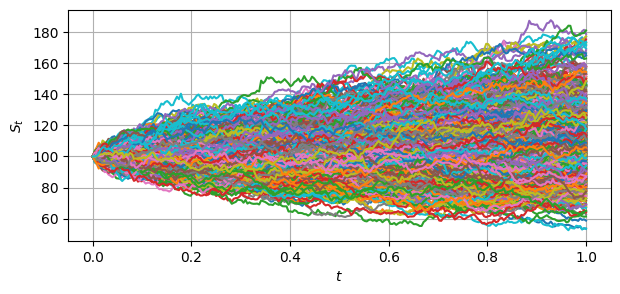

In [2]:
torch.manual_seed(42)

dt = torch.tensor(1 / 252)
T = 1.0
S0 = torch.tensor(100.0)

mu_true = torch.tensor(0.1)
delta_true = torch.tensor(2.0)
beta_true = torch.tensor(1.0)

cev_model = Cev(mu_true, delta_true, beta_true)

print(f"Init vol: {delta_true * S0 ** (beta_true/2 -1)}")

S = cev_model.simulate(S0, dt, T, M=1000)

plt.figure(figsize=(7,3))
plt.plot(torch.linspace(0, T, len(S)), S)
plt.xlabel(r'$t$')
plt.ylabel(r'$S_t$')
plt.grid()
plt.show()

/Users/ninocourtecuisse/Documents/ETHZ/MastersThesis/MastersThesis/.venv/lib/python3.11/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


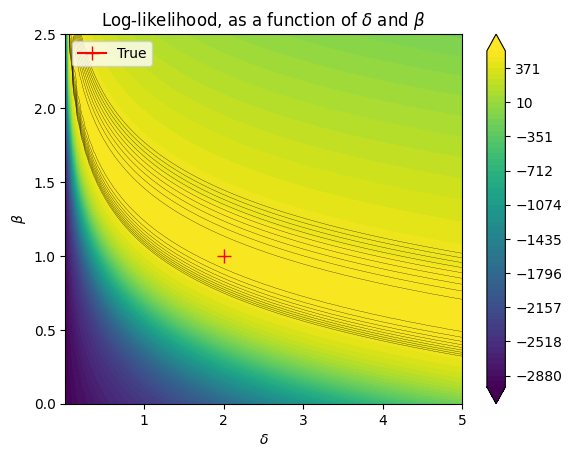

In [3]:
t = S.shape[0] - 1
spot = S[:, 0]

decay_coef = 1.0
window = 200

deltas = torch.linspace(0.01, 5.0, 100)
betas = torch.linspace(0.0, 2.5, 100)
deltas, betas = torch.meshgrid(deltas, betas)
log_likelihood = torch.zeros(size=(100, 100))
for i in range(deltas.shape[0]):
    for j in range(deltas.shape[1]):
        model = Cev(mu_true, deltas[i, j], betas[i, j])
        log_likelihood[i, j] = model.forward(spot, t, delta_t=dt, decay_coef=decay_coef, window=window)

min = torch.min(log_likelihood).detach()
max = torch.max(log_likelihood).detach()
levels = np.linspace(min, max, 60)
contour = plt.contourf(deltas, betas, log_likelihood.detach(), levels=levels, cmap='viridis', extend='both')
plt.colorbar(contour)
levels = np.linspace(max - 100, max, 10)
contour_line = plt.contour(deltas, betas, log_likelihood.detach(), levels=levels, colors='black', linewidths=0.2)


marker_plot = plt.plot(delta_true.item(), beta_true.item(), marker='+', color='red', markersize=10, label='True')
plt.legend(handles=marker_plot, loc='upper left')

plt.xlabel(r'$\delta$')
plt.ylabel(r'$\beta$')
plt.title(r'Log-likelihood, as a function of $\delta$ and $\beta$')
plt.show()

In [16]:
0.95**40

0.12851215656510312

In [39]:
torch.manual_seed(42)
t = S.shape[0] - 1

decay_coef = 1.0
window = 40

n_paths = S.shape[1]
n_params = 3
stats = {
    "mle": torch.zeros(size=(n_paths, n_params)),
    "max_value": torch.zeros(size=(n_paths,)),
    "n_it": torch.zeros(size=(n_paths,)),
    "no_convergence": 0,
}

max_it = 1000
grad_norm_threshold = 0.1
for i in range(n_paths):
    print(i)
    mu = Uniform(low=-0.5, high=0.5).sample()
    delta = Uniform(low=0.01, high=5).sample()
    beta = Uniform(low=1e-4, high=2.5).sample()

    #print("Init: ", mu.item(), delta.item(), beta.item())
    model = Cev(mu, delta, beta)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1, maximize=True)
    spot_prices = S[:, i]
    for j in range(max_it):
        optimizer.zero_grad()
        loss = model.forward(spot_prices, t=t, delta_t=dt, decay_coef=decay_coef, window=window)
        loss.backward()
        total_norm = torch.norm(torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None]))
        
        #print(f"Epoch {j}, Loss: {loss.item():.3f}, Grad Norm: {total_norm.item():.3f}")
        if total_norm < grad_norm_threshold:
            stats["n_it"][i] = j
            break
        if j == max_it - 1:
            stats["n_it"][i] = j
            stats["no_convergence"] += 1
            print("Maximum iteration reached.")
        optimizer.step()
    
    params = model.get_params()
    stats["mle"][i, 0] = params['mu']
    stats["mle"][i, 1] = params['delta']
    stats["mle"][i, 2] = params['beta']

    model = Cev(params['mu'], params['delta'], params['beta'])
    value = model.forward(spot_prices, t=t, delta_t=dt, decay_coef=decay_coef, window=window)
    stats["max_value"][i] = value

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
Maximum iteration reached.
18
19
20
21
22
Maximum iteration reached.
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
Maximum iteration reached.
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
Maximum iteration reached.
168
169
170
Maximum iteration reached.
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
Maximum iteration reached.
197
198
199
200
201
202
203
204
205
206
207
208
209
210
Maximum iteration reached.
211
212
Maximum iteration reached.
213
214
215
216
217
218
219
220
221
Maximu

In [40]:
mean = torch.mean(stats["mle"], dim=0)
std = torch.std(stats["mle"], dim=0)
avg_it = torch.mean(stats["n_it"])
n_no_conv = stats["no_convergence"]

true_params = torch.tensor([mu_true.item(), delta_true.item(), beta_true.item()])
avg_distance_to_argmax = torch.mean(torch.norm(stats["mle"] - true_params))

true_max_value = Cev(mu_true, delta_true, beta_true).forward(spot_prices, t=t, delta_t=dt, decay_coef=decay_coef, window=window).item()
avg_distance_to_max = torch.mean(torch.abs(stats["max_value"] - true_max_value)).item()

print(f"Average MLE: mu:{mean[0].item():.3f}, delta:{mean[1].item():.3f}, beta:{mean[2].item():.3f}")
print(f"Std MLE: mu:{std[0].item():.3f}, delta:{std[1].item():.3f}, beta:{std[2].item():.3f}")
print(f"Average distance to true parameter: {avg_distance_to_argmax.item():.3f}")
print(f"Average relative error to the true maximum: {((true_max_value - avg_distance_to_max) / true_max_value):.3f}")
print(f"Average number of iteration to convergence {avg_it.item():.3f}")
print(f"Number of parameters where GD didn't converge: {n_no_conv} / {n_paths}")

Average MLE: mu:0.070, delta:3.414, beta:0.933
Std MLE: mu:0.479, delta:3.177, beta:0.490
Average distance to true parameter: 112.095
Average relative error to the true maximum: 0.925
Average number of iteration to convergence 143.577
Number of parameters where GD didn't converge: 46 / 1000
